In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
#from tslearn.metrics import dtw
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, jaccard_score
from scipy.stats import pearsonr
from itertools import product

In [22]:

# Función para cargar y procesar datasets
def load_and_process_data(df):
    # Filtrar para tener un registro por participante
    df0 = df[df['Type'] == 0]
    df1 = df[df['Type'] == 1]

    # Merge de los datasets por 'Name' con método left
    df_merged = df0.merge(df1, on=['Name', 'Kyu-Dan'], how='left', suffixes=('_0', '_1'))
    df_merged = df_merged.drop(columns=['Name', 'Kyu-Dan'])

    return df_merged, true_labels

# Función para evaluar clustering
def evaluate_clustering(labels, data, algorithm_name):
    silhouette = silhouette_score(data, labels)
    dbi = davies_bouldin_score(data, labels)
    chi = calinski_harabasz_score(data, labels)
    
    print(f"\n Evaluación de {algorithm_name}")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {dbi:.4f}")
    print(f"Calinski-Harabasz Index: {chi:.4f}")
    return silhouette, dbi, chi

# Función para evaluar con etiquetas reales
def evaluate_supervised(labels_pred, labels_true, algorithm_name):
    ari = adjusted_rand_score(labels_true, labels_pred)
    nmi = normalized_mutual_info_score(labels_true, labels_pred)
    jaccard = jaccard_score(labels_true, labels_pred, average='macro')

    print(f"\n Comparación con Etiquetas Reales ({algorithm_name})")
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
    print(f"Jaccard Index: {jaccard:.4f}")
    return ari, nmi, jaccard

# Función para graficar métricas
def plot_metrics(metrics, names, title):
    df_metrics = pd.DataFrame(metrics, columns=['Silhouette', 'DBI', 'CHI'], index=names)
    df_metrics.plot(kind='bar', figsize=(10, 6), title=title)
    plt.xlabel('Modelo')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()
    
 # Funcion para buscar mejores hiperparametros para KMeans
def tune_kmeans(data):
    best_score = -1
    best_params = None
    
    param_grid = {
        'n_clusters': [3, 4, 5, 6, 7],
        'init': ['k-means++', 'random'],
        'max_iter': [100, 300, 500],
        'n_init': [5, 10, 20]
    }
    
    for params in product(*param_grid.values()):
        kmeans = KMeans(n_clusters=params[0], init=params[1], max_iter=params[2], n_init=params[3], random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        
        if score > best_score:
            best_score = score
            best_params = params
    
    print(f"Mejores parametros para K-Means: {best_params}")
    return best_params

# Funcion para buscar mejores hiperparametros para KMedoids
def tune_kmedoids(data):
    best_score = -1
    best_params = None
    
    param_grid = {
        'n_clusters': [3, 4, 5, 6, 7],
        'init': ['random'],
        'max_iter': [100, 300, 500]
    }
    
    for params in product(*param_grid.values()):
        kmedoids = KMedoids(n_clusters=params[0], metric="euclidean", init=params[1], max_iter=params[2], random_state=42)
        labels = kmedoids.fit_predict(data)
        score = silhouette_score(data, labels)
        
        if score > best_score:
            best_score = score
            best_params = params
    
    print(f"Mejores parametros para K-Medoids: {best_params}")
    return best_params

# Función para aplicar clustering
def apply_clustering(data, true_labels, dataset_name):
    print(f"\n Procesando dataset: {dataset_name}")
    metrics_list = []
    model_names = []
    
    # K-Means con valores por defecto
    kmeans_default = KMeans(n_clusters=3, random_state=42)
    kmeans_default_labels = kmeans_default.fit_predict(data)
    metrics_list.append(evaluate_clustering(kmeans_default_labels, data, "K-Means (Default)"))
    model_names.append("K-Means (Default)")
    
    # K-Means optimizado
    best_kmeans_params = tune_kmeans(data)
    kmeans_tuned = KMeans(n_clusters=best_kmeans_params[0], init=best_kmeans_params[1], max_iter=best_kmeans_params[2], n_init=best_kmeans_params[3], random_state=42)
    kmeans_tuned_labels = kmeans_tuned.fit_predict(data)
    metrics_list.append(evaluate_clustering(kmeans_tuned_labels, data, "K-Means (Tuned)"))
    model_names.append("K-Means (Tuned)")
    
    # K-Medoids con valores por defecto
    kmedoids_default = KMedoids(n_clusters=3, metric="euclidean", random_state=42)
    kmedoids_default_labels = kmedoids_default.fit_predict(data)
    metrics_list.append(evaluate_clustering(kmedoids_default_labels, data, "K-Medoids (Default)"))
    model_names.append("K-Medoids (Default)")
    
    # K-Medoids optimizado
    best_kmedoids_params = tune_kmedoids(data)
    kmedoids_tuned = KMedoids(n_clusters=best_kmedoids_params[0], metric="euclidean", init=best_kmedoids_params[1], max_iter=best_kmedoids_params[2], random_state=42)
    kmedoids_tuned_labels = kmedoids_tuned.fit_predict(data)
    metrics_list.append(evaluate_clustering(kmedoids_tuned_labels, data, "K-Medoids (Tuned)"))
    model_names.append("K-Medoids (Tuned)")
    
    plot_metrics(metrics_list, model_names, f"Comparación de Modelos - {dataset_name}")
    
    if true_labels is not None:
        evaluate_supervised(kmeans_default_labels, true_labels, "K-Means (Default)")
        evaluate_supervised(kmeans_tuned_labels, true_labels, "K-Means (Tuned)")
        evaluate_supervised(kmedoids_default_labels, true_labels, "K-Medoids (Default)")
        evaluate_supervised(kmedoids_tuned_labels, true_labels, "K-Medoids (Tuned)")



In [19]:
df_bokken= pd.read_csv("bokken_data_selected_features.csv", sep='|')
df_bokken.head()

,Name,Type,Kyu-Dan,ACCX_BOKKEN_0_Kurtosis,ACCX_BOKKEN_0_Mean absolute deviation,ACCX_BOKKEN_0_Median frequency,ACCX_BOKKEN_0_Skewness,ACCX_BOKKEN_0_Spectral entropy,ACCX_BOKKEN_0_Zero crossing rate,ACCY_BOKKEN_0_Kurtosis,...,ACCZ_BOKKEN_0_Spectral spread,ACCZ_BOKKEN_0_Zero crossing rate,MOD_ACC_0_Kurtosis,MOD_ACC_0_Mean absolute diff,MOD_ACC_0_Spectral centroid,Gender,BMI,Experience,Arm,Age
0,AikidoBudoCinco,1,1,4.015332,678.543206,6.039964,-2.127074,0.636564,73.0,2.791130,...,12.930947,138.0,2.029359,146.733642,9.509750,1,-0.154806,7.0,-0.089261,0.109204
1,AikidoBudoCinco,0,1,2.094608,826.097715,6.105458,-1.709932,0.656191,80.0,1.589994,...,12.612464,139.0,0.982322,187.290344,9.251720,1,-0.154806,7.0,-0.089261,0.109204
2,AikidoBudoCuatro,1,1,3.734143,698.137164,6.185567,-2.138073,0.705352,72.0,4.718044,...,12.535484,252.0,2.200972,171.437679,9.368745,1,0.393034,5.0,-0.958433,0.201924
3,AikidoBudoCuatro,0,1,2.583732,794.002380,6.093023,-1.885798,0.667974,55.0,3.876430,...,11.956373,278.0,1.653854,197.640497,9.990665,1,0.393034,5.0,-0.958433,0.201924
4,AikidoBudoDiez,0,0,0.948697,878.066049,4.415218,-1.378589,0.681308,42.0,0.785075,...,12.688987,144.0,1.763895,192.804029,9.459617,1,-1.183957,0.1,-0.089261,0.480083



 Procesando dataset: Bokken

 Evaluación de K-Means (Default)
Silhouette Score: 0.3084
Davies-Bouldin Index: 1.1047
Calinski-Harabasz Index: 122.1813
Mejores parametros para K-Means: (3, 'k-means++', 100, 5)

 Evaluación de K-Means (Tuned)
Silhouette Score: 0.3084
Davies-Bouldin Index: 1.1047
Calinski-Harabasz Index: 122.1813

 Evaluación de K-Medoids (Default)
Silhouette Score: 0.2742
Davies-Bouldin Index: 1.1891
Calinski-Harabasz Index: 107.7410
Mejores parametros para K-Medoids: (3, 'random', 100)

 Evaluación de K-Medoids (Tuned)
Silhouette Score: 0.3318
Davies-Bouldin Index: 1.0381
Calinski-Harabasz Index: 106.7474


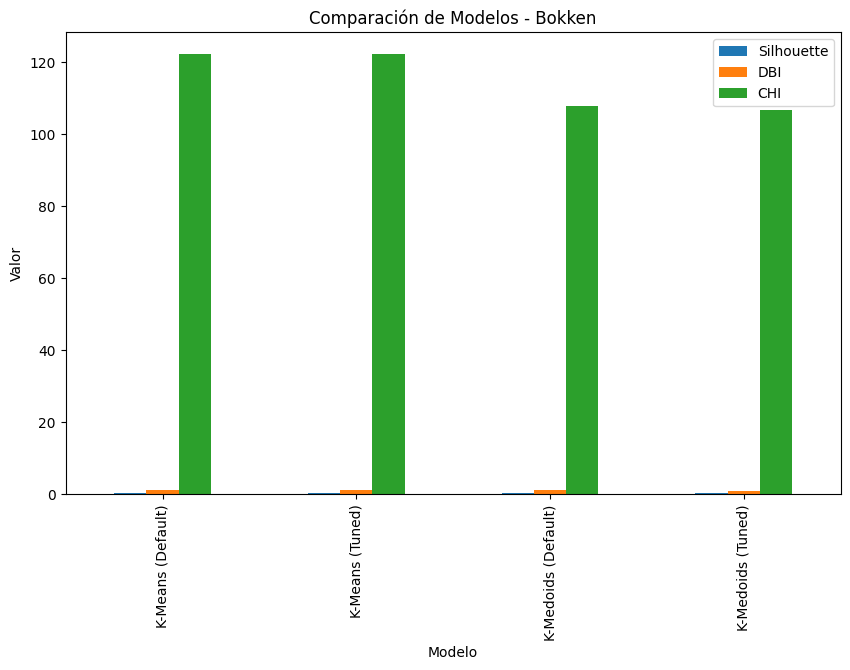


 Comparación con Etiquetas Reales (K-Means (Default))
Adjusted Rand Index (ARI): 0.0182
Normalized Mutual Information (NMI): 0.0243
Jaccard Index: 0.2689

 Comparación con Etiquetas Reales (K-Means (Tuned))
Adjusted Rand Index (ARI): 0.0182
Normalized Mutual Information (NMI): 0.0243
Jaccard Index: 0.2689

 Comparación con Etiquetas Reales (K-Medoids (Default))
Adjusted Rand Index (ARI): 0.0048
Normalized Mutual Information (NMI): 0.0173
Jaccard Index: 0.2205

 Comparación con Etiquetas Reales (K-Medoids (Tuned))
Adjusted Rand Index (ARI): 0.0181
Normalized Mutual Information (NMI): 0.0274
Jaccard Index: 0.2255


In [21]:
bokken_data, true_labels = load_and_process_data(df_bokken)
apply_clustering(bokken_data, true_labels, "Bokken")

In [29]:
df_shikko= pd.read_csv("shikko_data_selected_features.csv", sep='|')
df_shikko = df_shikko.drop_duplicates(subset=['Name', 'Type'])


 Procesando dataset: Shikko

 Evaluación de K-Means (Default)
Silhouette Score: 0.2689
Davies-Bouldin Index: 1.1548
Calinski-Harabasz Index: 111.9255
Mejores parametros para K-Means: (3, 'k-means++', 100, 5)

 Evaluación de K-Means (Tuned)
Silhouette Score: 0.2689
Davies-Bouldin Index: 1.1548
Calinski-Harabasz Index: 111.9255

 Evaluación de K-Medoids (Default)
Silhouette Score: 0.1661
Davies-Bouldin Index: 1.3529
Calinski-Harabasz Index: 66.3342
Mejores parametros para K-Medoids: (3, 'random', 100)

 Evaluación de K-Medoids (Tuned)
Silhouette Score: 0.2596
Davies-Bouldin Index: 1.1573
Calinski-Harabasz Index: 107.6231


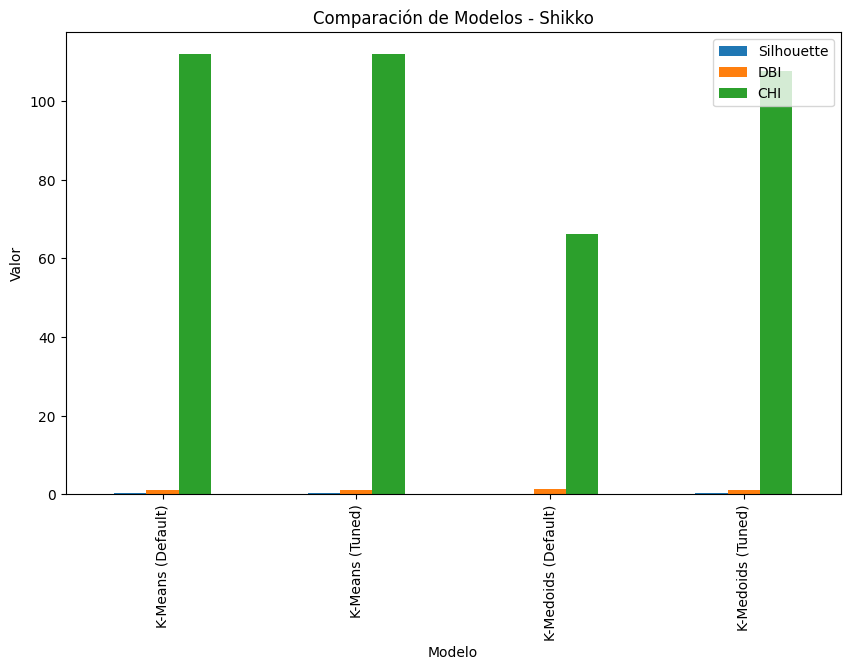

ValueError: Found input variables with inconsistent numbers of samples: [153, 185]

In [30]:
shikko_data, true_labels = load_and_process_data(df_shikko)
apply_clustering(shikko_data, true_labels, "Shikko")